<a href="https://colab.research.google.com/github/YasudaKaito/pytorch_book_akaishi/blob/main/ch07_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7

二値分類→多値分類で変わる点

- 出力: 1次元 → 分類クラス数N次元
    - 複数の分類器ができる
- 活性化関数: sigmoid → softmax
- 損失関数: 交差エントロピーの形式が変わる(下記)。
    - 分類クラス数が全部でN個
    - $yt_i$は正解のとき1,正解でないとき0
    - $yp_i$はsoftmaxの出力ベクトルの要素

$$
\sum_{i=0}^{N-1}(yt_i \log yp_i)
$$

- PyTorchのポリシーとして「対数関数と指数関数をセットで使うべき」があり、`CrossEntroyLoss`には softmax -> 交差エントロピーが一体になっている

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

In [3]:
x_org, y_org = iris.data, iris.target
print(x_org.shape)
print(y_org.shape)

(150, 4)
(150,)


In [4]:
# sepal がく片 length と petal 花弁 length のみ抽出
x_select = x_org[:, [0, 2]]
x_select.shape

(150, 2)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_select, y_org, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


In [7]:
import matplotlib.pyplot as plt

In [8]:
y_train[:5]

array([1, 1, 0, 2, 2])

In [9]:
# 訓練データを正解ラベルごとにグループ分けして散布図
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]
print(x_t0.shape, x_t1.shape, x_t2.shape)

(23, 2) (30, 2) (22, 2)


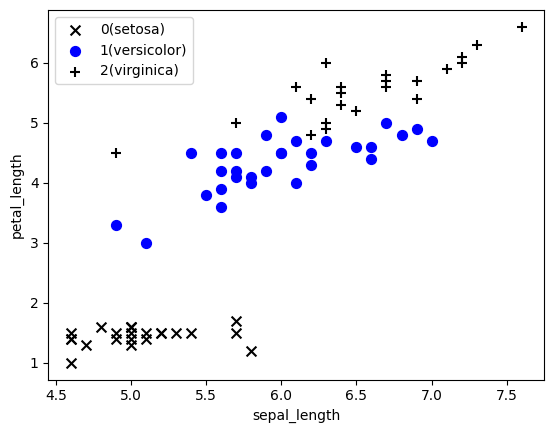

In [10]:
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker="x", c="k", s=50, label="0(setosa)")
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker="o", c="b", s=50, label="1(versicolor)")
plt.scatter(x_t2[:, 0], x_t2[:, 1], marker="+", c="k", s=50, label="2(virginica)")
plt.xlabel("sepal_length")
plt.ylabel("petal_length")
plt.legend()
plt.show()

In [11]:
# モデル定義
n_input = x_train.shape[1]
n_output = len(set(y_train))
print(n_input, n_output)

2 3


In [12]:
import torch.nn as nn

# 入力次元2, 出力次元3のロジスティック回帰モデル
class Net(nn.Module):
    def __init__(self, n_input, n_output) -> None:
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # 初期値は1
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        return self.l1(x)

net = Net(n_input, n_output)

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)

In [14]:
import torch

# shape: (75, 2)
inputs = torch.tensor(x_train).float()
# CrossEntropyLossの第二引数は整数型である必要がある
labels = torch.tensor(y_train).long()
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [15]:
import numpy as np

num_epochs = 10000
history = np.zeros((0, 5))

In [16]:
for epoch in range(num_epochs):
    # 訓練
    optimizer.zero_grad()
    # shape: (75, 3)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 列方向にmaxを集計 出力: (75)
    predicted = torch.max(outputs, 1)[1]
    train_loss = loss.item()
    train_acc = (predicted == labels).sum() / len(labels)

    # 予測
    outputs_test = net(inputs_test)
    loss_test = criterion(outputs_test, labels_test)
    predicted_test = torch.max(outputs_test, 1)[1]
    val_loss = loss_test.item()
    val_acc = (predicted_test == labels_test).sum() / len(labels_test)

    if (epoch % 10 == 0):
        print(f"Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f} val_acc: {val_acc:.5f}")
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263 val_acc: 0.26667
Epoch [10/10000], loss: 1.03580 acc: 0.40000 val_loss: 1.06403 val_acc: 0.26667
Epoch [20/10000], loss: 1.00477 acc: 0.40000 val_loss: 1.03347 val_acc: 0.26667
Epoch [30/10000], loss: 0.97672 acc: 0.40000 val_loss: 1.00264 val_acc: 0.26667
Epoch [40/10000], loss: 0.95057 acc: 0.41333 val_loss: 0.97351 val_acc: 0.26667
Epoch [50/10000], loss: 0.92616 acc: 0.48000 val_loss: 0.94631 val_acc: 0.38667
Epoch [60/10000], loss: 0.90338 acc: 0.69333 val_loss: 0.92098 val_acc: 0.56000
Epoch [70/10000], loss: 0.88212 acc: 0.70667 val_loss: 0.89740 val_acc: 0.60000
Epoch [80/10000], loss: 0.86227 acc: 0.70667 val_loss: 0.87545 val_acc: 0.61333
Epoch [90/10000], loss: 0.84373 acc: 0.70667 val_loss: 0.85500 val_acc: 0.62667
Epoch [100/10000], loss: 0.82640 acc: 0.70667 val_loss: 0.83594 val_acc: 0.62667
Epoch [110/10000], loss: 0.81019 acc: 0.72000 val_loss: 0.81815 val_acc: 0.62667
Epoch [120/10000], loss: 0.79500 acc: 0

In [20]:
# 正解データの0番目、2番目、3番目を抜き出す
print(labels[[0, 2, 3]])

tensor([1, 0, 2])


In [18]:
# 該当する入力値
i3 = inputs[[0, 2, 3],:]
print(i3.data.numpy())

[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [19]:
softmax = torch.nn.Softmax(dim=1)
# i3 shape: (3, 2) -> o3 shape: (3, 3)
o3 = net(i3)
# k3 shape: (3, 3) (列方向に softmax を適用、 列方向の合計が1となる)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

[[ 8.807065   14.193748   12.998567  ]
 [12.826232    9.799994    0.17343801]
 [ 6.7954063  15.092802   17.1111    ]]
[[3.5014052e-03 7.6497865e-01 2.3151995e-01]
 [9.5374250e-01 4.6254385e-02 3.0506512e-06]
 [2.9224984e-05 1.1729175e-01 8.8267905e-01]]
